# Create a Video from a Script and Images

This notebook pulls data from an Excel file containing a list of influential figures. It is able to convert text into speech and then combine this with images to produce a video ready for YouTube. The section at the end also allows the user to create a thumbnail for the video and produces a description from a template.

The scripts have been generated using ChatGPT with the prompt "Generate 10 pretty long and interesting facts about \<Influential Figure>". If a script is generated but no audio available then the code will create an audio file based on the script and a pre-made intro and outro. The user must add picutres to a folder of the figure and if they are available but no video produced then the code will calculate a duration for all images and create a video from these images and the audio clip.

Once that is done the video will be saved to the Videos folder but a copy will be in the main repository for ease when uploading to YouTube. You then can make a thumbnail out of images in the respective figures Images file or a seperate image before adding text to the image to make it stand out. A description is also returned for easy uploading.

## Load modules

In [65]:
import pandas as pd
import numpy as np
import os # Check folder contents
import shutil # Move thumbnail
import docx2txt # Import word files
import openpyxl # Save files to Excel
import random # For thumbnail
from PIL import Image, ImageFont, ImageDraw, ImageFilter # Resizing thumbnail and adding text

## Load/Prepare Data Files

### Set Locations

Here we set all of the locations for the data as well as loading in the pre-made Intro, Description, and Outro.

In [66]:
script_loc = "./Scripts/"
images_loc = "./Images/"
set_scripts_loc = "./Set Scripts/"
audio_loc = "./Audio/"
video_loc = "./Video/"

# Get the Intro
intro = docx2txt.process(set_scripts_loc + 'Intro.docx')

# Get the Description
description = docx2txt.process(set_scripts_loc + 'Description.docx')

# Get the Outro
outro = docx2txt.process(set_scripts_loc + 'Outro.docx')

### Load the dataframe of information

Here we load in the dataframe containing the information on the influential figures before adding the prompt and making sure we have no duplicates in the names. We the overwrite the file.

In [71]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')

In [72]:
# Create the ChatGPT prompt
historical_figures_list['Prompt'] = "Generate 10 pretty long and interesting facts about " + historical_figures_list['Name']
# Remove duplicate names
historical_figures_list = historical_figures_list.drop_duplicates(subset = ['Name'])


# Posted Videos
posted_list = historical_figures_list[(historical_figures_list.Youtube_Video_Posted == "Yes")]

# Videos Made
video_made_list = historical_figures_list[(historical_figures_list.Youtube_Video_Created == "Yes") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
video_made_list = video_made_list.sample(frac = 1)

# Images Added
images_made_list = historical_figures_list[(historical_figures_list.Images_Obtained == "Yes") &
                                           (historical_figures_list.Youtube_Video_Created == "No") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
images_made_list = images_made_list.sample(frac = 1)

# Voice Generated
audio_made_list = historical_figures_list[(historical_figures_list.AI_Voice_Generated == "Yes") &
                                           (historical_figures_list.Images_Obtained == "No") &
                                           (historical_figures_list.Youtube_Video_Created == "No") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
audio_made_list = audio_made_list.sample(frac = 1)

# Script Generated
script_made_list = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                           (historical_figures_list.AI_Voice_Generated == "No") &
                                           (historical_figures_list.Images_Obtained == "No") &
                                           (historical_figures_list.Youtube_Video_Created == "No") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
script_made_list = script_made_list.sample(frac = 1)

# No Script Generated
no_script_made_list = historical_figures_list[(historical_figures_list.Script_Created == "No")]
no_script_made_list = no_script_made_list.sample(frac = 1)

# Update the figure list
historical_figures_list = pd.concat([posted_list, video_made_list, images_made_list,
                                     audio_made_list,script_made_list,no_script_made_list])

historical_figures_list['Figure_ID'] = range(len(historical_figures_list))
historical_figures_list['Figure_ID'] = historical_figures_list['Figure_ID'] + 1

historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

## Create Any Necessary Audio Files

This code checks if there are any figures who have a script saved but no audio. If there isn't any audio then the code creates some and saves it to the Audio folder with the figures name as the file name. It then updates the Excel file to show that the audio has been saved.

In [5]:
# Here we want to capture any figures who need audio. We can create this in one loop.
need_audio = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "No")]

In [6]:
need_audio

,Figure_ID,Name,Description,Script_Created,AI_Voice_Generated,Images_Obtained,Youtube_Video_Created,Youtube_Video_Posted,Youtube_URL,Prompt


In [7]:
def generate_audio(text_loc, voice, intro = "./Set Scripts/Intro.docx",
                   outro = "./Set Scripts/Outro.docx", save_loc = "./Audio/"):

    # Get the script
    data = docx2txt.process(text_loc)
    # Remove any of the elements below
    data = data.replace('\r', ' ').replace('\n\n', ' ').replace('\n', ' ')
    # Get the intro and outro
    intro = docx2txt.process(intro)
    outro = docx2txt.process(outro)
    # Combine the three
    data = intro + "  " + data + "  " + outro
    
    # Replace any quotation marks
    data = data.replace('"', "'")
    
    # Complete the command
    command1 = f'edge-tts --voice "{voice}" --text "{data}" --write-media "{save_loc}"'
    os.system(command1)

In [8]:
# We only do this if audio is needed
if need_audio.shape[0] > 0:
    # These libraries are only needed here
    import edge_tts
    from edge_tts import VoicesManager
    import random
    
    # Randomly choose an English US voice
    voices = await VoicesManager.create()
    # Get the list of english US voices
    voice = voices.find(Language="en", Locale="en-US")
    # Filter out annoying voice
    voice = list(filter(lambda v: v['ShortName'] != 'en-US-AnaNeural', voice))
    
    # Create figure filepaths
    figure_scripts = list(need_audio.iloc[:,1].values + '.docx')
    
    # Now want to loop through the figures, getting the script, the figures name and then
    # saving the audio before changing the value in the Excel file for needs audio to yes.
    for figure in figure_scripts:
        
        # Choose random voice out of those remaining
        voice_chosen = random.choice(voice)["ShortName"]
        
        # Get the figure name
        fig = os.path.splitext(figure)[0]
        
        # Location of the scripts
        text_loc = script_loc + figure
        
        # Location to save the audio
        save_loc = audio_loc + fig + ".mp3"
        
        # Run the generate_audio function
        generate_audio(text_loc, voice_chosen, save_loc = save_loc)
        
        # Convert the No to Yes in needs audio column
        historical_figures_list.iloc[(historical_figures_list.Name == fig),4] = "Yes"
    
        # Once all done stop the engine and then overwrite the Excel file
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
    
    print("Complete, my guy!")

## COMMENT OUT - THIS IS FOR MAC WILL ADJUST WHEN ABLE

In [9]:
#import gtts # Speech to text
# make request to google to get synthesis
#tts = gtts.gTTS(my_text, tld= "co.uk")
# save the audio file
#tts.save("hello.mp3")

In [10]:
# play the audio file
# playsound("hello.mp3")

## Check For Images

Next we want to check to see if there are any figures who have images in the Images folder but i have forgot to change the images value to yes

In [17]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')
# We grab any that still need images
need_images = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                      (historical_figures_list.AI_Voice_Generated == "Yes") &
                                      (historical_figures_list.Images_Obtained == "No")]

In [18]:
# If there are figures with images needed we will check to see if there are actually images there and then if there
# are we will change the images obtained value to yes.
if need_images.shape[0] > 0:
    
    # List all of the figures needing images
    figures_image = list(need_images.iloc[:,1].values)
    
    for figure in figures_image:
        # Create the filepath
        image_path = images_loc + figure
        
        # If there are any figures where the folder path exists
        if os.path.exists(image_path) == True:
            # Check the number of files and if more than zero. Make changes to document
            if len(os.listdir(image_path + '/')) > 0:
                historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
                historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
          
need_images = need_images[(need_images.Images_Obtained == "No")]

In [19]:
need_images

,Figure_ID,Name,Description,Script_Created,AI_Voice_Generated,Images_Obtained,Youtube_Video_Created,Youtube_Video_Posted,Youtube_URL,Prompt
18,20,Frida Kahlo,Renowned Mexican painter and feminist icon.,Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...
39,48,Pythagoras,"Developed the Pythagorean theorem, which is on...",Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...
40,50,Theodore Roosevelt,"26th President of the United States, he was a ...",Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...
41,51,Thomas Jefferson,"3rd President of the United States, he was a m...",Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...
42,52,Tupac Shakur,One of the most influential rappers of all tim...,Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...
43,53,Voltaire,One of the most important Enlightenment thinke...,Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...
44,55,Harriet Tubman,Fought for the abolition of slavery and helped...,Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...
45,56,Jimi Hendrix,One of the most influential guitarists of all ...,Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...
46,57,Muhammad Ali,"One of the most successful boxers of all time,...",Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...
47,58,Mother Teresa,"Founded the Missionaries of Charity, a Roman C...",Yes,Yes,No,No,No,NaN,Generate 10 pretty long and interesting facts ...


If there are no images for any figures which have audio complete then we need to find some imgaes. To do this we will use Selenium and google image search for each figure. We then will loop through images and allow the user to reply y/n until 10 images have been selected.

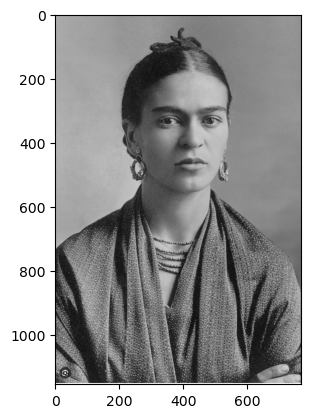

Frida Kahlo Image 1 - Keep this image? Y or N: y
Use as thumbnail? Y or N: y


/var/folders/xx/hy496x3x5sn4hy9gy1fk19lw0000gp/T/ipykernel_8738/3442879246.py:104: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)
/var/folders/xx/hy496x3x5sn4hy9gy1fk19lw0000gp/T/ipykernel_8738/3442879246.py:107: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)


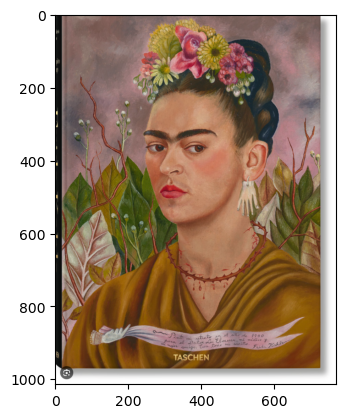

Frida Kahlo Image 2 - Keep this image? Y or N: n


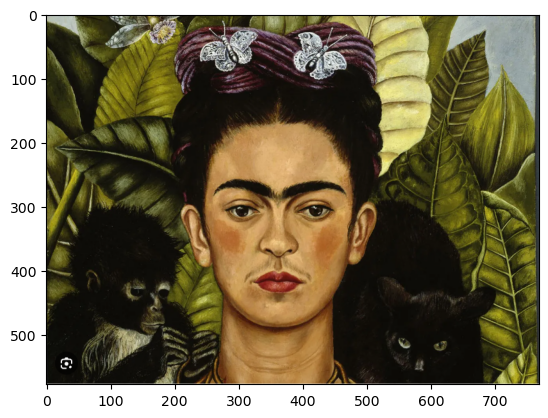

Frida Kahlo Image 2 - Keep this image? Y or N: y
Use as thumbnail? Y or N: y


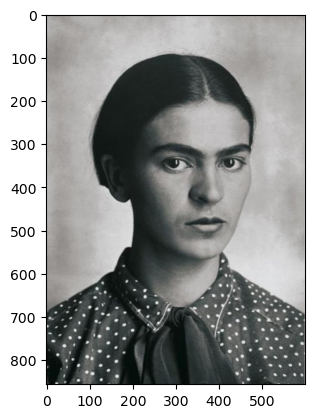

Frida Kahlo Image 3 - Keep this image? Y or N: y
Use as thumbnail? Y or N: y


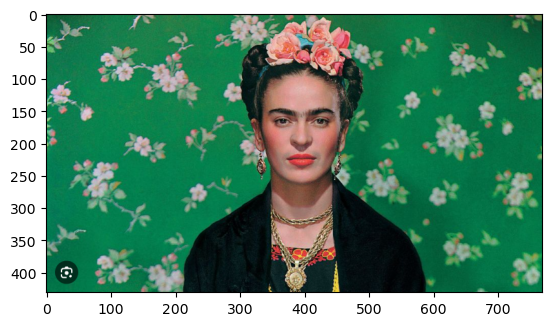

Frida Kahlo Image 4 - Keep this image? Y or N: y
Use as thumbnail? Y or N: n


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[3]/div[1]/a/img[1]"}
  (Session info: chrome=115.0.5790.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
0   chromedriver                        0x000000010043ff48 chromedriver + 4226888
1   chromedriver                        0x00000001004384f4 chromedriver + 4195572
2   chromedriver                        0x000000010007cd68 chromedriver + 281960
3   chromedriver                        0x00000001000b7fc8 chromedriver + 524232
4   chromedriver                        0x00000001000eec58 chromedriver + 748632
5   chromedriver                        0x00000001000abf1c chromedriver + 474908
6   chromedriver                        0x00000001000acef4 chromedriver + 478964
7   chromedriver                        0x000000010040159c chromedriver + 3970460
8   chromedriver                        0x00000001004056f0 chromedriver + 3987184
9   chromedriver                        0x000000010040b5b4 chromedriver + 4011444
10  chromedriver                        0x00000001004062fc chromedriver + 3990268
11  chromedriver                        0x00000001003de1c0 chromedriver + 3826112
12  chromedriver                        0x0000000100422088 chromedriver + 4104328
13  chromedriver                        0x00000001004221e0 chromedriver + 4104672
14  chromedriver                        0x0000000100431f28 chromedriver + 4169512
15  libsystem_pthread.dylib             0x0000000199e7bfa8 _pthread_start + 148
16  libsystem_pthread.dylib             0x0000000199e76da0 thread_start + 8


In [19]:
# We only do this if images are needed
if need_images.shape[0] > 0:
    
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    # Get the dominant colour of the image
    from colorthief import ColorThief
    #from selenium.webdriver.common.keys import Keys
    
    # List all of the figures needing images
    figures_image = list(need_images.iloc[:,1].values)
    
    quality_val = 90
    # Loop a google images search across figures.
    for figure in figures_image:
        # Create the filepath
        image_path = images_loc + figure
        
        # Create the figure directory to save the images if needed
        isExist = os.path.exists(image_path)
        if not isExist:
            os.makedirs(image_path)
        
        #----GOOGLE IMAGE SEARCH CODE----#
        
        # What you enter here will be searched for in Google Images
        query = figure

        #desired_dpi = 2.0
        #options = Options()
        #options.add_argument(f"--force-device-scale-factor={desired_dpi}")
        # Creating a webdriver instance
        driver = webdriver.Chrome()

        # Maximize the screen
        driver.maximize_window()

        # Open Google Images in the browser
        driver.get('https://images.google.com/')

        # Clear cookies - INSPECT and then use click option then copy xpath
        driver.find_element('xpath', '//*[@id="L2AGLb"]').click()

        # Finding the search box - INSPECT and then use click option then copy xpath
        box = driver.find_element("xpath", '//*[@id="APjFqb"]')

        # Type the search query in the search box
        box.send_keys(query)

        # Pressing enter
        #box.send_keys(Keys.ENTER)
        
        # click the search button - INSPECT and then use click option then copy xpath
        driver.find_element('xpath', '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/button').click()
        
        # Now we want to loop across the images to let user selected whether to keep or not
        i = 1
        images_kept = 0
        thumbnail_options = 1
        while images_kept < 10:
            # Here i represents the image shown on the screen - want to click it to expand
            driver.find_element('xpath','//*[@id="islrg"]/div[1]/div[' + str(i) + ']/a[1]/div[1]/img').click()

            # Get the image aspect of the expanded image - INSPECT and then use click option then copy xpath
            imgResults = driver.find_element('xpath',
                                             '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[3]/div[1]/a/img[1]')
            
            # //*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[3]/div[1]/a/img[1]
            # /html/body/div[2]/c-wiz/div[3]/div[2]/div[3]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[3]/div[1]/a/img[1]
            # Save the image
            imgResults.screenshot('test.png')

            # Load as image object
            selected_clicked_image = Image.open('test.png')

            # This plots the image so we can see it
            %matplotlib inline
            import matplotlib.pyplot as plt
            import matplotlib.image as mpimg
            img = mpimg.imread('test.png')
            imgplot = plt.imshow(img)
            plt.show()
    
            # Text to display to give option of saving image
            keep = input(figure + " Image " + str(images_kept + 1) + " - Keep this image? Y or N: ")
    
            # If keep then save the image and increment
            if keep == "Y" or keep == "y":
                
                # Text to whether i want to save the image as a thumbnail option
                thumbnail = input("Use as thumbnail? Y or N: ")
                
                if thumbnail == "Y" or thumbnail == "y":
                    selected_clicked_image.save(image_path + "/thumbnail" + str(thumbnail_options) + ".png", 
                                                quality=quality_val)
                    thumbnail_options += 1
                
                # We want all images to be the same size. If they aren't resize them.
                h = selected_clicked_image.height
                w = selected_clicked_image.width
                
                if h > 480:
                    h = 480
                    selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)
                if w > 720:
                    w = 720
                    selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)

                start_pos_w = 360 - w/2
                start_pos_h = 240 - h/2
 
                # Want to paste the resized image onto dominant colour background
                color_thief = ColorThief('test.png')
                # get the dominant color
                dominant_color = color_thief.get_color(quality=1)
                # Background
                bk = Image.new('RGB', (720, 480), color = dominant_color)
                # paste background image on to border image
                bk.paste(selected_clicked_image, (int(start_pos_w), int(start_pos_h)))
                
                bk.save(image_path + "/" + str(images_kept + 1) + '.png',
                       quality=quality_val)
                
                images_kept += 1
    
            i += 1
        
        # Change the image obtained to yes for the specified figure and save
        historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
        
        # Remove the test image
        os.remove('test.png')
        
        # Close the driver
        driver.minimize_window()
        driver.close()

    

## Manual Image Adding

In [46]:
def manual_image_generator(image_location, figure, image_number,
                          thumbnail_num = 0, images_complete = False):

    image_path = images_loc + figure
    
    quality_val = 90
        
    # Create the figure directory to save the images if needed
    isExist = os.path.exists(image_path)
    if not isExist:
        os.makedirs(image_path)
        
    #----GOOGLE IMAGE SEARCH CODE----#
    save_location = image_path + "/" + str(image_number) + ".png"
    # Load as image object
    selected_clicked_image = Image.open(image_location)
                
    if thumbnail_num > 0:
        selected_clicked_image.save(image_path + "/thumbnail" + str(thumbnail_num) + ".png", 
                                                quality=quality_val)
                
    # We want all images to be the same size. If they aren't resize them.
    h = selected_clicked_image.height
    w = selected_clicked_image.width
                
    if h > 480:
        h = 480
        selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)
    if w > 720:
        w = 720
        selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)

    start_pos_w = 360 - w/2
    start_pos_h = 240 - h/2
 
    # Want to paste the resized image onto dominant colour background
    color_thief = ColorThief(image_location)
    # get the dominant color
    dominant_color = color_thief.get_color(quality=1)
    # Background
    bk = Image.new('RGB', (720, 480), color = dominant_color)
    # paste background image on to border image
    bk.paste(selected_clicked_image, (int(start_pos_w), int(start_pos_h)))
                
    bk.save(save_location, quality=quality_val)
        
    # Remove the test image
    os.remove(image_location)
    
    if images_complete == True:
        # Change the image obtained to yes for the specified figure and save
        historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
   

In [47]:
manual_image_generator('/Users/user/Documents/GitHub/Video-from-Script/Images/Frida Kahlo/Lola-Alvarez-Bravo-Arturo-Estrada-and-Frida-Kahlo-in-Exhibition_web_0.jpg',
                      'Frida Kahlo',
                      14, images_complete = True)

/var/folders/xx/hy496x3x5sn4hy9gy1fk19lw0000gp/T/ipykernel_8738/1619184889.py:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)
/var/folders/xx/hy496x3x5sn4hy9gy1fk19lw0000gp/T/ipykernel_8738/1619184889.py:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)


## Add Video

Next we wish to check if any figures have a script, an audio and images available but there is no video recorded. If this is the case then the code will loop through the figures and combine the audio and images together to create a vide and save it in the Video folder before finally adjusting the table to show this.

In [48]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')
# We will grab any figures who have a script and audio complete but no video.
need_video = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "Yes") &
                                     (historical_figures_list.Images_Obtained == "Yes") &
                                     (historical_figures_list.Youtube_Video_Created == "No")]

In [49]:
need_video

,Figure_ID,Name,Description,Script_Created,AI_Voice_Generated,Images_Obtained,Youtube_Video_Created,Youtube_Video_Posted,Youtube_URL,Prompt
18,20,Frida Kahlo,Renowned Mexican painter and feminist icon.,Yes,Yes,Yes,No,No,NaN,Generate 10 pretty long and interesting facts ...


In [50]:
if need_video.shape[0] > 0:
    from moviepy.editor import *
    os.environ["IMAGEIO_FFMPEG_EXE"] = "ffmpeg"
    # Get the figures who need a video making
    figure_video = list(need_video.iloc[:,1].values)
    
    for figure in figure_video:
        # Get the locations
        audio_location = audio_loc + figure + '.mp3'
        image_location = images_loc + figure + '/'
        video_location = video_loc + figure + '.mp4'
        
        # Add audio clip and get the duration
        audio_clip = AudioFileClip(audio_location)
        audio_duration = audio_clip.duration
        
        # Get the time each image will show for, remove thumbnail options
        possible_images = os.listdir(image_location)
        possible_images = [image for image in possible_images if "thumbnail" not in image]
        
        number_of_images = len(possible_images)
        image_duration = audio_duration / number_of_images

        # Here we create the frames for each image and their duration
        img_names = possible_images
        img = list(image_location + img for img in img_names)

        clips = [ImageClip(m).set_duration(image_duration)
                 for m in img]

        # Combine the images together into a single clip
        concat_clip = concatenate_videoclips(clips, method = "compose")

        # add the audio
        concat_clip.audio = audio_clip

        # Write the video with audio included
        concat_clip.write_videofile(video_location, fps = 24)

        # Add Yes to the video created column
        historical_figures_list.iloc[(historical_figures_list.Name == figure),6] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

Moviepy - Building video ./Video/Frida Kahlo.mp4.
MoviePy - Writing audio in Frida KahloTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ./Video/Frida Kahlo.mp4



Moviepy - Done !
Moviepy - video ready ./Video/Frida Kahlo.mp4


## Functions for Youtube Upload

Here are the functions used in the upload process

In [51]:
def create_description(string, string_to_replace, figure):
    # Create YouTube description
    modified_string = string.replace(string_to_replace, figure)
    print(modified_string)

In [52]:
def move_video(figure):
    # We want to move the video to the main file directory
    import shutil
    video_location = video_loc + figure + '.mp4'
    shutil.copy2(video_location, "video.mp4")

In [53]:
def thumbnail_generator(image_location, title_text, YT_logo_location, YT_channel,
                       font_location, save_location):

    # Add image as an object
    my_image = Image.open(image_location)

    # 1280 × 720 pixels - thumbnail size
    max_image_size = (1280, 720)

    # Set the image size to the max
    my_image.thumbnail(max_image_size)

    ### PROFILE PICTURE IN CORNER ###
    # Add the youtube profile picture
    profile_pic = Image.open(YT_logo_location).convert("RGBA")
    # Add random background, doesn't matter what
    background = Image.new("RGBA", profile_pic.size, (0,0,0,0))

    mask = Image.new("RGBA", profile_pic.size, 0)
    draw = ImageDraw.Draw(mask)
    
    # Crop the circle
    draw.ellipse((0,0,int(profile_pic.size[0]),int(profile_pic.size[0])),
                 fill='green', outline=None)

    # Make the image
    profile_pic = Image.composite(profile_pic, background, mask)

    # resize profile pic
    profile_pic = profile_pic.resize((200, 200))

    ### GET DOMINANT COLOUR FOR BACKGROUND AND TEXT COLOUR ###
    
    # Get the dominant colour of the image
    from colorthief import ColorThief
    color_thief = ColorThief(image_location)
    # get the dominant color
    dominant_color = color_thief.get_color(quality=1)

    # To get whether text will be white or black
    if (0.299 * dominant_color[0]) + (0.587 * dominant_color[1]) + (0.114 * dominant_color[2]) > 186:
        contrast_colour = tuple([0, 0, 0])
    else: 
            contrast_colour= tuple([255, 255, 255])

    ### PASTE IMAGES TOGETHER ###
    
    # Sizing down image 
    my_image = my_image.resize((int(500), 680))

    # Create background and add the border and background image
    # Border
    img = Image.new('RGB', (1280, 720), color = contrast_colour)
    # Background
    img2 = Image.new('RGB', (1260, 700), color = dominant_color)
    # paste background image on to border image
    img.paste(img2, (10, 10))
    # Add my image on top
    img.paste(my_image, (20, 20))
    # Add the profile pic
    img.paste(profile_pic, (1060, 500), mask = profile_pic)

    ### FONTSIZE GENERATOR ###
    
    # Get the text for the title
    title_text = title_text
    
    fontsize = 1  # starting font size
    # Get the font and initialise the size
    font = ImageFont.truetype(font_location, fontsize)
    # Remaining size of image
    breakpoint = 720
    # Large jumps to speed up process
    jumpsize = 75

    # Loops through fontsizes and finds the max which fits all of the text
    while True:
        if font.getsize(title_text)[0] < breakpoint:
            fontsize += jumpsize
        else:
            jumpsize = jumpsize // 2
            fontsize -= jumpsize
        font = ImageFont.truetype(font_location, fontsize)
        if jumpsize <= 1:
            break

    # This returned huge font for small number of characters so workaround in place
    # This was done with trial and error
    if fontsize > 190:
        fontsize = 190
        font = ImageFont.truetype(font_location, fontsize)
        subtitle_size = int(fontsize / 2)
        start_pos = -20
        subtitle_start = 160
    elif fontsize <= 100:
        subtitle_size = 90
        start_pos = 20
        subtitle_start = 50 + int(fontsize / 2)
    else:
        subtitle_size = int(fontsize / 2)
        start_pos = - 10
        subtitle_start = 80 + int(fontsize / 2)

    # Allow for drawing on the image
    image_editable = ImageDraw.Draw(img)

    # Add the title
    image_editable.text((540, start_pos), title_text, contrast_colour, font = font)

    # Add the subtitle
    title_font = ImageFont.truetype(font_location, subtitle_size )
    title_text = "10 Interesting Facts"
    image_editable.text((540, subtitle_start), title_text, contrast_colour, font = title_font)

    # Add the youtube handle
    title_font = ImageFont.truetype(font_location, 40)
    title_text = YT_channel
    image_editable.text((540, 655), title_text, contrast_colour, font = title_font)

    img.show()

    img.save(save_location)


## Youtube Preparation

In [54]:
def YouTube_preparation(historical_figure):
    move_video(historical_figure)
    print("#--------------------TITLE--------------------#\n")
    print(historical_figure, "- 10 Interesting Facts\n")
    print("#-----------------DESCRIPTION-----------------#\n")
    create_description(description, "[Historical Figure]", historical_figure)
    
    # Images for tumbnail function
    image_location = images_loc + historical_figure + "/"
    all_images = os.listdir(image_location)
    thumbnails = [x for x in all_images if x.startswith('t')]
    
    for thumbnail in thumbnails:
        save_location = "./Thumbnails/" + historical_figure + "-" + thumbnail
        thumbnail_generator(image_location = image_location + thumbnail,
                            title_text = historical_figure,
                            YT_logo_location = 'YT Profile.jpg',
                            YT_channel = "@Figures_In_History",
                            font_location = "./Fonts/Bebas-Regular.ttf",
                            save_location = save_location)
    
    i = 0
    while i == 0:
        string = "Choose which thumbnail you would like to use: 1 to " + str(len(thumbnails))
        thumbnail_choice = input(string)
          
        if int(thumbnail_choice) > len(thumbnails):
            i = 0
        else:
            file_loc = "./Thumbnails/" + historical_figure + "-" + "thumbnail" + thumbnail_choice + ".png"
            shutil.copy(file_loc, "thumbnail.png")
            i = 1

In [57]:
YouTube_preparation('Frida Kahlo')

#--------------------TITLE--------------------#

Frida Kahlo - 10 Interesting Facts

#-----------------DESCRIPTION-----------------#

Welcome to Figures in History! In this episode, we delve into the life and legacy of Frida Kahlo. Join us as we uncover ten key facts about this influential individual who left an indelible mark on history. From their groundbreaking achievements to their remarkable journey, we explore the captivating story behind Frida Kahlo

Subscribe to Figures in History for more captivating stories of influential figures who shaped our world. Don't forget to hit the notification bell to stay updated with our latest episodes. We value your input, so leave a comment below and let us know which historical figure you'd like to see featured in future episodes. Your suggestions matter to us

Join us on this incredible journey through time and discover the inspiring stories that have shaped our world. Remember, it's through understanding the past that we shape a brighter fu